In [2]:
# !pip install sklearn
# !pip3 install osqp==0.6.1
# !pip3 install fancyimpute
# !pip install missingpy

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [102]:
df = pd.read_csv('processed/df.csv')
df_encoded = pd.read_csv('processed/df_encoded.csv')
df_numeric = pd.read_csv('processed/df_numeric.csv')
numerical_columns = [line.strip() for line in open('processed/numerical_columns.txt', 'r')]
categorical_columns = [line.strip() for line in open('processed/categorical_columns.txt', 'r')]

# Missing values

## Identification of missing data

In [103]:

def print_range_of_values(dataframe):
    for col in dataframe.columns:
        print(col, '\t',dataframe[col].unique())
        
print_range_of_values(df[categorical_columns])


specific_gravity 	 ['_1.020' '_1.010' '_1.005' '_1.015' nan '_1.025']
albumin 	 ['_1' '_4' '_2' '_3' '_0' nan '_5']
sugar 	 ['_0' '_3' '_4' '_1' nan '_2' '_5']
red_blood_cells 	 [nan 'normal' 'abnormal']
pus_cell 	 ['normal' 'abnormal' nan]
pus_cell_clumps 	 ['notpresent' 'present' nan]
bacteria 	 ['notpresent' 'present' nan]
hypertension 	 [ 1.  0. nan]
diabetes_mellitus 	 [ 1.  0. nan]
coronary_artery_disease 	 [ 0.  1. nan]
appetite 	 ['good' 'poor' nan]
pedal_edema 	 [ 0.  1. nan]
anemia 	 [ 0.  1. nan]
class 	 [1 0]


In [104]:
def get_nr_none(dataframe):
    cols = []
    for col in dataframe.columns:
        total = len(df)
        none = np.count_nonzero(dataframe[col].isnull().values)
        ratio = none/total
        cols.append((col, total, none, ratio))
    return sorted(cols, key=lambda tup: tup[3], reverse=True)

def print_nr_none(dataframe):
    nr_none = get_nr_none(dataframe)
    print('column \t total \t none \t ratio')
    for col, total, none, ratio in nr_none:
        print(col, '\t', total, '\t', none, '\t', ratio)

In [105]:
print_nr_none(df)

column 	 total 	 none 	 ratio
red_blood_cells 	 400 	 152 	 0.38
red_blood_cell_count 	 400 	 131 	 0.3275
white_blood_cell_count 	 400 	 106 	 0.265
potassium 	 400 	 88 	 0.22
sodium 	 400 	 87 	 0.2175
packed_cell_volume 	 400 	 71 	 0.1775
pus_cell 	 400 	 65 	 0.1625
hemoglobin 	 400 	 52 	 0.13
sugar 	 400 	 49 	 0.1225
specific_gravity 	 400 	 47 	 0.1175
albumin 	 400 	 46 	 0.115
blood_glucose_random 	 400 	 44 	 0.11
blood_urea 	 400 	 19 	 0.0475
serum_creatinine 	 400 	 17 	 0.0425
blood_pressure 	 400 	 12 	 0.03
age 	 400 	 9 	 0.0225
pus_cell_clumps 	 400 	 4 	 0.01
bacteria 	 400 	 4 	 0.01
hypertension 	 400 	 2 	 0.005
diabetes_mellitus 	 400 	 2 	 0.005
coronary_artery_disease 	 400 	 2 	 0.005
appetite 	 400 	 1 	 0.0025
pedal_edema 	 400 	 1 	 0.0025
anemia 	 400 	 1 	 0.0025
class 	 400 	 0 	 0.0


#### Summary
- rbc (red blood cells [normal / abnormal]) has a missing value ratio of 43%
- rbcc (red blood cell count (numerical)) has a missing value ratio of 38%
- wbcc (white blood cell count) has a missing value ratio of 30%
- pot, sod, pcv have missing value ratios between 20% and 25%
- pc, hemo, su, sg, al, bgr have missing value ratios between 10% and 20%
- the rest have a missing value ratio of less than 6%.  

### Evaluating the dataset without missing values

In [106]:
df_without_nan = df.dropna()
df_without_nan.describe()


,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,pedal_edema,anemia,class
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,49.563291,74.050633,131.341772,52.575949,2.188608,138.848101,4.636709,13.687342,41.917722,8475.949367,4.891772,0.215190,0.177215,0.069620,0.126582,0.101266,0.272152
std,15.512244,11.175381,64.939832,47.395382,3.077615,7.489421,3.476351,2.882204,9.105164,3126.880181,1.019364,0.412261,0.383065,0.255315,0.333562,0.302640,0.446483
min,6.000000,50.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000,9.000000,3800.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.250000,60.000000,97.000000,26.000000,0.700000,135.000000,3.700000,12.600000,37.500000,6525.000000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,80.000000,115.500000,39.500000,1.100000,139.000000,4.500000,14.250000,44.000000,7800.000000,4.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,80.000000,131.750000,49.750000,1.600000,144.000000,4.900000,15.775000,48.000000,9775.000000,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,83.000000,110.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From a total of 400 rows, 158 rows have no missing values. A lot of statistical power gets lost if all the nan values are dropped.

### No columns are dropped

As we have found out in the exploratory data analysis, all of our columns except potassium have a some correlation with the class variable. Potassium could be dropped but since 

## Imputation


In [107]:

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report


# Select columns with numerical data

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'Iterative': IterativeImputer(random_state=0),
}


In [108]:
for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df_numeric.copy()
    df_imputed[df_numeric.columns] = imputer.fit_transform(df_numeric)
    df_imputed.to_csv(f'imputed/{impute_name}.csv', index=False)


Imputing with mean method
Imputing with median method
Imputing with mode method
Imputing with KNN method
Imputing with MICE method
Imputing with Iterative method


## Removing NaN and None values by imputation
Due to the high dimensionaltiy of our data, a visualization of the missing values and its impact on the dataset to find out the missing value mechanism is not feasible.

To find out whether the missing values in this data set are MNAR, we would need to have measurements of some of the missing values. Since that is out of scope for our project, we assume that they are at least MAR. To be sure to have as little bias as possible, we will use multiple imputation methods to impute the missing values. We will use the mice package for this.

For the multiple imputation to work as intended, the dataset needs to be imputed as a whole. Categorical data and numerical cannot be imputed separately, otherwise correlations are not preserved. 

But since the mice model cannot deal with categorical data, we perform a one-hot encoding of the dataset.
nan values will appear as seperate columns since the one-hot encoder cannot deal with them. 

Therefore, we need to add the nan values separately afterwards.


Problem: how can categorical and numerical values be combined in one model? We cannot perform decision tree inputation on the numerical values and neither can we perform regression classification on the categorical values.
--> the data need to be treated seperately.

In [109]:
df_imputed = pd.read_csv('imputed/MICE.csv')
df_imputed

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.849783,1.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,0.785533,1.0,0.0,0.0,130.217255,...,38.0,6000.0,4.647384,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,1.000000,1.0,0.0,0.0,423.000000,...,31.0,7500.0,3.821081,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,1.000000,0.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,1.000000,1.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,140.000000,...,47.0,6700.0,4.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
396,42.0,70.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,75.000000,...,54.0,7800.0,6.200000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397,12.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,100.000000,...,49.0,6600.0,5.400000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
398,17.0,60.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,114.000000,...,51.0,7200.0,5.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0


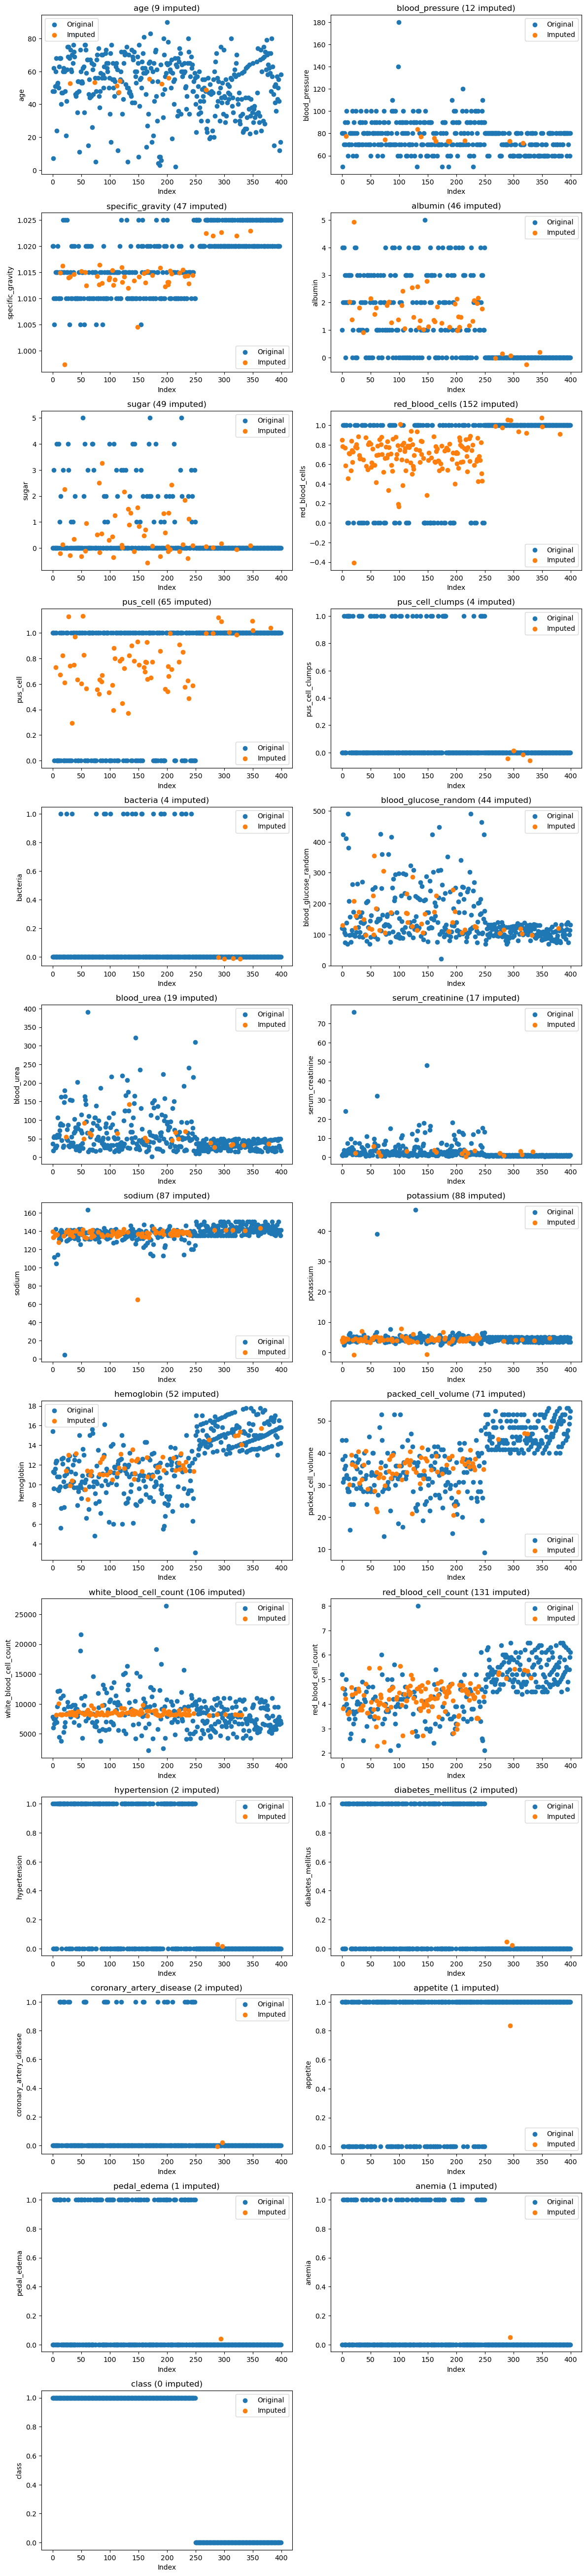

In [110]:

columns = df_imputed.columns

# Calculate the number of rows and columns for the subplots
num_plots = len(columns)
num_rows = 20  # Adjust the number of rows as desired
num_cols = int(np.ceil(num_plots / num_rows))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Flatten the axes array
axes = axes.flatten()

# Iterate through the columns and create the overlay plots
for i, col in enumerate(columns):
    ax = axes[i]  # Select the appropriate subplot

    imputed = [x if np.isnan(df_numeric[col][j]) else None for j, x in enumerate(df_imputed[col]) ]
    # Plot the original values
    ax.scatter(df_numeric.index, df_numeric[col], label='Original')

    # Plot the imputed values
    ax.scatter(df_imputed.index, imputed, label='Imputed')

    nr_imputed = len(list(filter(lambda imp: imp != None, imputed)))
    ax.set_xlabel('Index')
    ax.set_ylabel(col)
    ax.set_title(f'{col} ({nr_imputed} imputed)')
    ax.legend()

# Remove any unused subplots
if num_plots < len(axes):
    for ax in axes[num_plots:]:
        ax.remove()

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show()

## Fixing the categorical columns

## todo